In [1]:
import numba as nb
import numpy as np
from basis1d import *

import spectral_stats as sps
from spectral_stats.spectra import Spectra
import matplotlib.pyplot as plt

In [46]:

energies = np.sort(np.random.poisson(1000., (10,30)) + np.random.uniform(low=-1, high=1, size=(10,30)) - 1000, axis=1)
spectrum = Spectra(energies)
spectrum.spectral_unfolding(n=5, merge=False, correct_slope=True)

energies_ = spectrum.spectrum

Performing spectral unfolding with the following settings: 
n: 5, merge: False, correct_slope: True 
spectral_width: (0.0, 1.0)


In [38]:
import numpy as np
import numba as nb


@nb.jit('float64[:](float64, float64[:])', fastmath=True, nogil=True)
def sigma_num_variance(L, E):
    """
    A function that calculates number variance for
    an energy spectrum.

    Definition of sigma:

        sigma**2(L)=<N(L)**2> - <N(L)>**2

    where L is the width of the energy interval in the spectrum
    and N is the number of energy levels inside the interval L.
    < ... > denotes a moving window average over different levels
    in the spectrum.

    INPUT:

    L - energy interval width
    E - energies, a particular energy spectrum

    OUTPUT:

    A vector containing three quantities:
    <N(L)>
    sigma**2(L)
    variance of sigma**2

    """

    result = np.zeros(shape=3, dtype=np.float64)

    Ave1 = 0.0
    Ave2 = 0.0
    Ave3 = 0.0
    Ave4 = 0.0

    j = 1
    k = 1

    x = E[0]

    ndata = E.shape[0]

    # Count the number of values in the interval.
    # If L is large, make sure that the loop
    # does not iterate over the limit.
    while ((E[k] < x + L)):

        if k == ndata - 1:
            break
        else:
            k += 1
    
    print('k is: {}'.format(k))
    print('E[k] is: {}'.format(E[k]))
    # Perform the actual calculation -
    # Move the energy window over the energy interval
    # and sum the contributions to Ave1, Ave2, Ave3, Ave4
    # during the process.
    # while (x <= E[ndata-1]):
    while ((k <= ndata - 1) and (x <= E[ndata - 1])):

        d1 = E[j] - x
        d2 = E[k] - (x + L)
        cn = 1. * (k - j)

        if d1 < d2:
            x = E[j]
            s = d1
            j += 1
        else:
            x = E[k] - L
            s = d2
            k += 1
            
        print('x is: {}'.format(x))
        print('s is: {}'.format(s))
        print('j is: {}'.format(j))
        print('k is: {}'.format(k))

        Ave1 = Ave1 + s * cn
        Ave2 = Ave2 + s * cn ** 2
        Ave3 = Ave3 + s * cn ** 3
        Ave4 = Ave4 + s * cn ** 4

    s = x - E[0]
    # s = E[ndata -1] - E[0]

    # Ave1 = Ave1 / s
    Ave1 = Ave1 / s
    Ave2 = Ave2 / s
    Ave3 = Ave3 / s
    Ave4 = Ave4 / s

    AveNum = Ave1  # AveNum
    AveSig = Ave2 - AveNum ** 2  # AveSig
    VarSig = 1. * Ave4 - 4. * Ave3 * AveNum + 8. * Ave2 * AveNum ** 2 - \
        4. * AveNum ** 4 - Ave2 ** 2

    result[0] = AveNum
    result[1] = AveSig
    result[2] = VarSig

    return result


@nb.jit('float64[:,:](float64[:], float64[:])', fastmath=True,
         parallel=True, nogil=True)
def sigma_loop(L, E):
    """
    A function that calculates sigma**2(L) dependence
    by calling the sigma_num_variance function
    for different L values.

    INPUT:

    L - an array of L values
    E - an array of energy values, a particular energy spectrum

    OUTPUT:
    (arrays) for <N(L)>, sigma**2(L) and variance of sigma**2.

    """

    # ndata = E.shape[0]
    nL = L.shape[0]

    NumVar = np.zeros(shape=(3, nL), dtype=np.float64)
    res_size = 3
    result = np.zeros(shape=res_size, dtype=np.float64)

    for i in nb.prange(nL):

        result = sigma_num_variance(L[i], E)

        for j in range(res_size):
            NumVar[j, i] = result[j]

    return NumVar


@nb.jit('float64[:,:](float64[:], float64[:,:], b1)',
        fastmath=True)
def sigma_averaged(L, E, deviation=False):
    """
    A function that averages different sigma loop
    calculations obtained for different disorder
    realizations.

    INPUT:

    L - a list of L values
    E - a list of energy spectra for different
        disorder realizations
    deviation - boolean, whether deviations
                are also calculated

    If deviation == False:
        The output shape is the same as in the
        sigma_loop function's case.
    else:
        Also the errors for the quantities are returned

    """
    nsamples = E.shape[0]
    nL = L.shape[0]

    if not deviation:
        results = np.zeros(shape=(3, nL), dtype=np.float64)

        for i in range(nsamples):

            results += sigma_loop(L, E[i])

        return results * 1. / nsamples
    else:
        results = np.zeros(shape=(6, nL), dtype=np.float64)

        partial = np.zeros(shape=(nsamples, 3, nL), dtype=np.float64)

        for i in range(nsamples):

            partial[i] = sigma_loop(L, E[i])

        results[:3] = np.mean(partial, axis=0)
        results[3:] = np.std(partial, axis=0)

        return results


In [44]:
sigma_num_variance(31, energies_[0])
print(energies_[0][0], energies_[0][-1])
print(energies_)

k is: 28

E[k] is: 29.9939430504

x is: -1.00605694964

s is: -1.39341848658

j is: 1

k is: 29

(0.3873615369398191, 29.993943050362134)
[[ 0.38736154  2.68815989  5.30207883  6.95597237  6.9588488   7.02884523
   8.38451753  8.38654128  8.69297593 10.3726586  11.54176394 11.92456807
  12.65745329 16.23302898 17.0676334  18.66717216 18.68117001 20.15312019
  20.2287264  20.48643792 20.86607933 21.05807572 21.90446711 26.14349263
  26.5067643  27.33239704 27.96746818 28.54515157 29.99394305]]


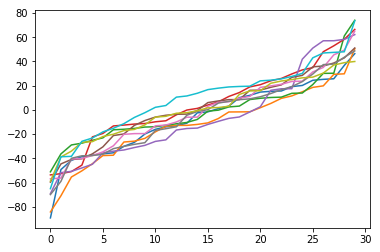

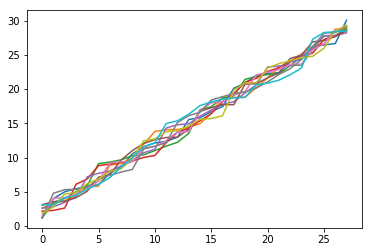

{'correct_slope': True,
 'discarded_unfolding': 2,
 'merged_unfolding': False,
 'n': 5,
 'spectral_width': (0.0, 1.0),
 'unfolding_performed': True}

In [47]:
fig = plt.figure()
for spc in spectrum._spectrum0:
    plt.plot(spc)
plt.show()

fig1 = plt.figure()
for spc in spectrum.spectrum:
    plt.plot(spc)
plt.show()





spectrum.unfold_dict

In [93]:
spectrum._filtering_performed

False

In [15]:
# calculate level variance
Lvals = np.arange(1., 1000., 1.)
spectrum.calc_lvl_var(Lvals)

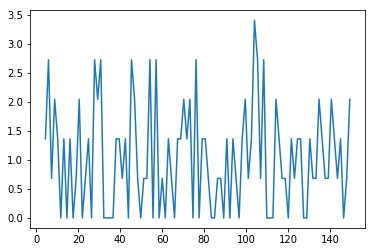

In [16]:
hist, edges = spectrum.hist(100)

plt.plot(edges[1:], hist*spectrum.nener)

IndexError: too many indices for array

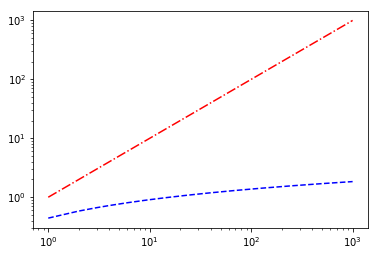

In [48]:

def numvar_GOE(Lvals):
    eu = np.pi**2 / 8.
    gamma = 0.577
    return 2 * (np.log(2 * np.pi * Lvals) + 1 + gamma - eu) / np.pi**2
    # return 2*np.log(Lvals)/np.pi**2


def numvar_poisson(Lvals):

    return Lvals
fig = plt.figure()
plt.loglog(Lvals, numvar_GOE(Lvals), color='blue', ls='--')
plt.loglog(Lvals, numvar_poisson(Lvals), color='red', ls='-.')
plt.loglog(spectrum.lvals, (spectrum.lvl_var)[1], color='green')
plt.ylim(0.1, 1000)